This notebook is to enhance my skills on feature engineering and visualization of the Geo-Spatial variables(geographic latitude and longitude) data. I have taken inputs from online and kaggle.In this notebook I will be working on california housing data.

Feature Engineering of the Geo-Spatial variables and find the following for each data point.

The name of the nearest city.

The distance from the district's coordinates to the nearest city.

The population of the nearest city.

The nearest 'big city' (a big city is categorized as >500,000 residents in the given year, 1990).

The distance to the nearest 'big city'.

In [1]:
#Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import xgboost as xgb


from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import StratifiedShuffleSplit     #stratified shiffle split to maintain the distribution
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from geopy.distance import vincenty                            #to calculate the actual geographic distance 

import gc #importing garbage collector

In [2]:
housing = pd.read_csv('housing.csv')                           #reading the data
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [3]:
city_lat_long = pd.read_csv('cal_cities_lat_long.csv')        #reading the latitude and longitude data
city_lat_long.head()

Name   Latitude   Longitude
0      Adelanto  34.582769 -117.409214
1  Agoura Hills  34.153339 -118.761675
2       Alameda  37.765206 -122.241636
3        Albany  37.886869 -122.297747
4      Alhambra  34.095286 -118.127014

In [4]:
city_pop_data = pd.read_csv('cal_populations_city.csv')        #reading the population data of the city
city_pop_data.head()

County          City Incorportation_date  pop_april_1980  \
0  San Bernardino      Adelanto                1970          2164.0   
1     Los Angeles  Agoura Hills                1982             NaN   
2         Alameda       Alameda                1854         63852.0   
3         Alameda        Albany                1908         15130.0   
4     Los Angeles      Alhambra                1903         64767.0   

   pop_april_1990  pop_april_2000  pop_april_2010  
0            8517           18130           31765  
1           20390           20537           20330  
2           76459           72259           73812  
3           16327           16444           18539  
4           82106           85804           83089

In [5]:
county_pop_data = pd.read_csv('cal_populations_county.csv')    # reading the population data of the county
county_pop_data.head()

County          City Incorportation_date  pop_april_1980  \
0  San Bernardino      Adelanto                1970          2164.0   
1     Los Angeles  Agoura Hills                1982             NaN   
2         Alameda       Alameda                1854         63852.0   
3         Alameda        Albany                1908         15130.0   
4     Los Angeles      Alhambra                1903         64767.0   

   pop_april_1990  pop_april_2000  pop_april_2010  
0            8517           18130           31765  
1           20390           20537           20330  
2           76459           72259           73812  
3           16327           16444           18539  
4           82106           85804           83089

The code below iterates through the coordinates dataframe and builds a dictonary with the city names as the keys and a tuple of the corresponding (latitude, longitude) as the values.

In [6]:
city_coords = {}

for dat in city_lat_long.iterrows():
    row = dat[1]
    if row['Name'] not in city_pop_data['City'].values:   
        continue           
    else: 
        city_coords[row['Name']] = (float(row['Latitude']), float(row['Longitude']))

Two functions are needed to find the distance to the nearest town, first one to determine the distance between two sets of coordinates, and second a function to try all pairwise comparisons and figure out which city is the closest.

In [7]:
# to determine the distance between two sets of coordinates

def closest_point(location, location_dict):
    closest_location = None
    for city in location_dict.keys():
        distance = vincenty(location, location_dict[city]).kilometers
        if closest_location is None:
            closest_location=(city,distance)
        elif distance < closest_location[1]:
            closest_location=(city,distance)
    return closest_location

In [8]:
#to determine both the nearest city, and then
#also the nearest city with 1million people (subset the original dict)

city_pop_dict = {}
for dat in city_pop_data.iterrows():
    row=dat[1]
    city_pop_dict[row['City']] = row['pop_april_1990']
    

big_cities = {}

for key,value in city_coords.items():
    if city_pop_dict[key]>500000:
        big_cities[key] = value

In [9]:
#adding closest city data to dataframes

housing['close_city'] = housing.apply(lambda x: closest_point((x['latitude'],x['longitude']),city_coords),axis = 1)
housing['close_city_name'] = [x[0] for x in housing['close_city'].values]
housing['close_city_dist'] = [x[1] for x in housing['close_city'].values]
housing['closest_city_pop'] = [city_pop_dict[x] for x in housing['close_city_name'].values]

housing = housing.drop('close_city',axis =1)
housing.head()


longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

  close_city_name  close_city_dist  closest_city_pop  
0        Berkeley         3.874956            102724  
1          Orinda         4.025281             16642  
2        Piedmont         2.938276             10602  
3        Berkeley         3.122559            102724  
4        Berkeley         3.122559            102724

In [10]:
#add the data relating to the points to the closest big city
housing['big_city'] = housing.apply(lambda x: closest_point((x['latitude'],x['longitude']),big_cities),axis=1)
housing['big_city_name'] = [x[0] for x in housing['big_city'].values]
housing['big_city_dist']= [ x[1] for x in housing['big_city'].values]

housing = housing.drop('big_city', axis=1)
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

  close_city_name  close_city_dist  closest_city_pop  big_city_name  \
0        Berkeley         3.874956            102724  San Francisco   
1          Orinda         4.025281             16642  San Francisco   
2        Piedmont         2.938276             10602  San Francisco   
3        Berkeley         3.122559            102724  San Francisco   
4        Berkeley         3.122559            102724  San Francisco   

   big_city_dist  
0      20.349081  
1      19.936328  
2      17.861202  
3      17.087267  
4      17.087267

In [11]:
#Housekeeping, plot background image load and new df for graphing

california_img  =mpimg.imread('california.png')

housing_plot = housing[['longitude', 'population', 'latitude', 'close_city_name', 'big_city_name','big_city_dist','median_house_value']]

# Visualizing the data

Map of the location and population of housing districts, along with a heatmap to show where homes are the most expensive.

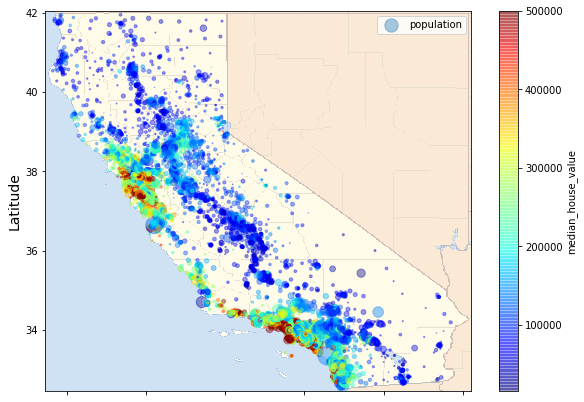

In [12]:
housing_plot.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=housing_plot['population']/100,
                 label='population',figsize=(10,7),c='median_house_value', cmap=plt.get_cmap('jet'),colorbar=True)

plt.imshow(california_img,extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel('Latitude',fontsize=14)
plt.xlabel('Longitude',fontsize=14)
plt.legend()
plt.show()

Below we have a graph showing the size and location of the cities in the dataset

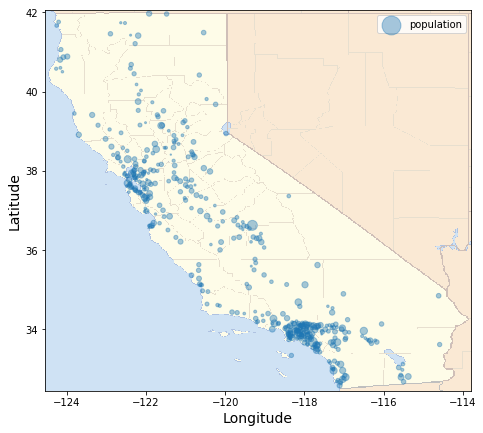

In [13]:
city_lat_long['Population'] = [city_pop_dict[x] if x in city_pop_dict.keys() 
                                                else 0 for x in city_lat_long['Name'].values]

city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude',  alpha=0.4,
                    s=housing_plot['population']/50, label='population', figsize=(10,7))

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()

Engineered Features - Length of vectors between districts and nearest town (Vincenty's formulae)

The map below provides a visualization of three of the features added to the data. The black lines represent the vectors connecting the districts to the nearest town. Based on these lines, the distance to the nearest town (length of black line), the population of the nearest town (point the black line arrives at) and a categorical for the name of the nearest town were assigned to the district

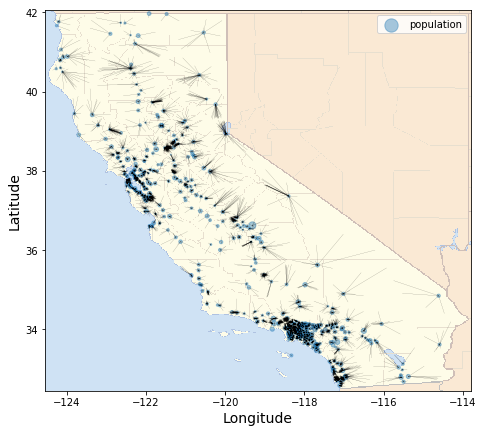

In [14]:
# graph of vectors connecting points to their nearest city
city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude',  alpha=0.4,
                    s=housing_plot['population']/100, label='population', figsize=(10,7))

for line in housing.iterrows():
    dat = line[1]
    x1 = dat['longitude']
    y1 = dat['latitude']
    p2 = city_coords[dat['close_city_name']]
    x2 = p2[1]
    y2 = p2[0]
    plt.plot([x1,x2],[y1, y2], 'k-',linewidth=0.1)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

Engineered Features - Distance to the big city

This set of features shows which big city (San Francisco, San Jose, San Diego or Los Angeles... those are all really religious spanish names!) a given district is closest to. The cutoff for 'big city' was 500,000 people (this is 1990 data remember). The black lines here represent the same information as the previous plot, and each district was given a value for the distance to the nearest big city (Vincenty) and a categorical for the name of the nearest big city. I decided to add these features in because the proximity to a large city is somthing I intuitively thought would impact a house price. Access to things like major aiports and major entertainment events/venues could all have a small but important effect of the price of a home.

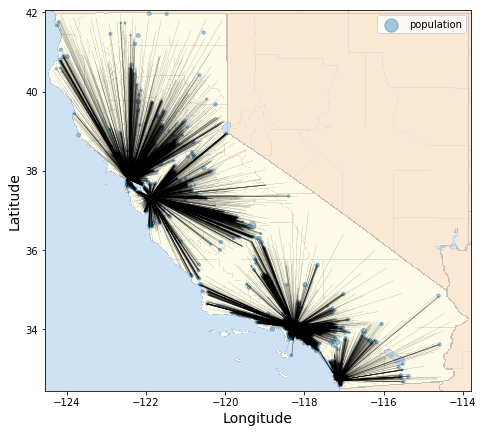

In [15]:
# graph of the vectors connecting districts to the nearest major city
# and a barplot of distance to the nearest major city


city_lat_long.plot(kind='scatter', x='Longitude', y='Latitude',  alpha=0.4,
                    s=housing_plot['population']/100, label='population', figsize=(10,7))

for line in housing.iterrows():
    dat = line[1]
    x1 = dat['longitude']
    y1 = dat['latitude']
    p2 = big_cities[dat['big_city_name']]
    x2 = p2[1]
    y2 = p2[0]
    plt.plot([x1,x2],[y1, y2], 'k-',linewidth=0.1)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()


In [16]:
#####
# Alter existing features, train test split.
#####

# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
#this change below is because column names can't be passed to xgboost with a < symbol
housing['ocean_proximity'][housing['ocean_proximity'] == '<1H OCEAN'] = 'LessThan1h'

#make a stratified split of the data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

gc.collect()

def housing_data_clean(input_df):
    input_df['rooms_per_household'] = input_df['total_rooms']/input_df['households']
    input_df['bedrooms_per_household'] = input_df['total_bedrooms']/input_df['households']
    input_df['bedrooms_per_room'] = input_df['total_bedrooms']/input_df['total_rooms']
    input_df['population_per_household'] = input_df['population']/input_df['households']
    input_df = input_df.drop(['total_bedrooms','total_rooms'], axis=1)
    return input_df

train_set = housing_data_clean(train_set)
train_set.head()
#do the same to the test set at the same time so they remain consistent with one another!
test_set = housing_data_clean(test_set)

X_train = train_set.drop('median_house_value', axis=1)
y_train = train_set['median_house_value'].values.astype(float)

X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].values.astype(float)


#####
# fill numerical values
#####

def fill_median(dataframe, cols):
    """impute the mean for a list of columns in the dataframe"""
    for i in cols:
        dataframe[i].fillna(dataframe[i].median(skipna=True), inplace = True)
    return dataframe

def cols_with_missing_values(dataframe):
    """ query a dataframe and find the columns that have missing values"""
    return list(dataframe.columns[dataframe.isnull().any()])

def fill_value(dataframe, col, val):
    """impute the value for a list column in the dataframe"""
    """ use this to impute the median of the train into the test"""
    dataframe[i].fillna(val, inplace = True)
    return dataframe

missing_vals = cols_with_missing_values(X_train)
X_train = fill_median(X_train, missing_vals)

for i in missing_vals:
    X_test = fill_value(X_test, i, X_train[i].median(skipna=True))


C:\Users\gvsva\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [17]:
#####
# One hot encode the categoricals
#####

encoder1 = LabelBinarizer()
encoded_ocean_train_1hot = encoder1.fit_transform(X_train['ocean_proximity'])
#I'm using just transform below to ensure that the categories are sorted and used the same as in the train fit.
encoded_ocean_test_1hot = encoder1.transform(X_test['ocean_proximity']) 


encoder2 = LabelBinarizer()
encoded_train_close_city = encoder2.fit_transform(X_train['close_city_name'])
encoded_test_close_city = encoder2.transform(X_test['close_city_name'])


encoder3 = LabelBinarizer()
encoded_train_big_city = encoder3.fit_transform(X_train['big_city_name'])
encoded_test_big_city = encoder3.transform(X_test['big_city_name'])


all_classes = list(encoder1.classes_) + [x + '_city' for x in encoder2.classes_ ]  + [x + '_Bigcity' for x in encoder3.classes_]

train_bool_data = np.concatenate((encoded_ocean_train_1hot, encoded_train_close_city, encoded_train_big_city), axis=1)
test_bool_data = np.concatenate((encoded_ocean_test_1hot, encoded_test_close_city, encoded_test_big_city), axis=1)

train_cat_df = pd.DataFrame(train_bool_data,
    index = X_train.index, columns = all_classes )

test_cat_df = pd.DataFrame(test_bool_data,index = X_test.index, columns = all_classes)

In [18]:
###
# Combine and scale the dfs
###

X_train.drop(['ocean_proximity','close_city_name','big_city_name'], axis=1, inplace=True)
X_test.drop(['ocean_proximity','close_city_name','big_city_name'], axis=1, inplace=True)


num_cols = X_train.columns
num_train_index = X_train.index
num_test_index = X_test.index

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


X_train = pd.DataFrame(X_train,index = num_train_index, columns = num_cols)
X_test = pd.DataFrame(X_test,index = num_test_index, columns = num_cols)


X_train = pd.concat([X_train, train_cat_df], axis=1)
X_test = pd.concat([X_test, test_cat_df], axis=1)



In [19]:
dtrain = xgb.DMatrix(X_train, y_train)

In [20]:
dtest = xgb.DMatrix(X_test)

In [21]:
y_mean = np.mean(y_train)

In [22]:
import multiprocessing
n_cpus_avaliable = multiprocessing.cpu_count()
print(f'we\'ve got {n_cpus_avaliable} cpus to work with.')

we've got 8 cpus to work with.


In [23]:
#after performing cv and for learning rate 0.05 best num_boost_round=1648
xgb_params = {'eta' :  0.05,
                'max_depth' :  8,
                'subsample' : 0.80, 
                'objective' :  'reg:linear',
                'eval_metric' : 'rmse',
                'base_score' :  y_mean,
                'nthread' : n_cpus_avaliable}

In [24]:
model = xgb.train(xgb_params, dtrain, 
                  num_boost_round=1648)

In [25]:
xgb_pred = model.predict(dtest)

In [26]:
test_mse = np.mean(((xgb_pred - y_test)**2))
test_rmse = np.sqrt(test_mse)
print(f'final test rmse: {test_rmse} with 1648 prediction rounds used')

final test rmse: 41430.137441695144 with 1648 prediction rounds used


$46146.47 was the root mean squared error for a single xgboost algorithm run on the original dataset.
So by adding in some new features, and training a roughly equivalent model, we have greatly decreased the rmse to 41430.137441695144 and 
The final test rmse for 10039 prediction rounds is 40781.61.
Stating thatadding new features can always contribute to lower prediction errors of the median income.